In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from mlxtend.plotting import plot_decision_regions
import random

### creating our own datafame to show the working of the adaboost

In [2]:
df = pd.DataFrame()

In [3]:
df['X1'] = [1,2,3,4,5,6,6,7,9,9]
df['X2'] = [5,3,6,8,1,9,5,8,9,2]
df['label'] = [1,1,0,1,0,1,0,1,0,0]

In [4]:
df

,X1,X2,label
0,1,5,1
1,2,3,1
2,3,6,0
3,4,8,1
4,5,1,0
5,6,9,1
6,6,5,0
7,7,8,1
8,9,9,0
9,9,2,0


### Plotting the dataframe

<Axes: xlabel='X1', ylabel='X2'>

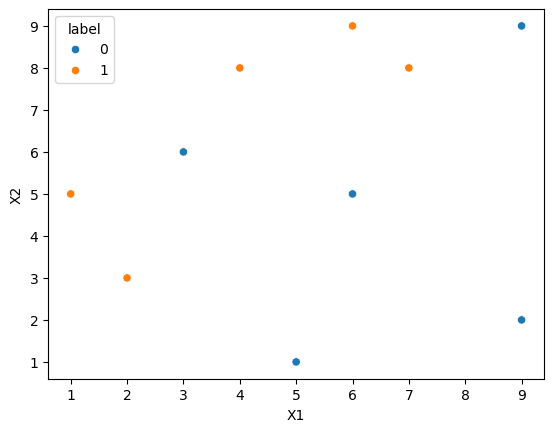

In [5]:
sns.scatterplot(x=df['X1'], y=df['X2'], hue=df['label'])

### assigning equal weights to every row 

In [6]:
df['weights'] = 1/df.shape[0]

In [7]:
df

,X1,X2,label,weights
0,1,5,1,0.1
1,2,3,1,0.1
2,3,6,0,0.1
3,4,8,1,0.1
4,5,1,0,0.1
5,6,9,1,0.1
6,6,5,0,0.1
7,7,8,1,0.1
8,9,9,0,0.1
9,9,2,0,0.1


### using decision tree classifier with max depth 1 to create a decision stump

In [8]:
dt1 = DecisionTreeClassifier(max_depth=1)

### extracting x and y

In [9]:
x = df.iloc[:,0:2]
y = df.iloc[:,2]

In [10]:
x

,X1,X2
0,1,5
1,2,3
2,3,6
3,4,8
4,5,1
5,6,9
6,6,5
7,7,8
8,9,9
9,9,2


In [11]:
y

0    1
1    1
2    0
3    1
4    0
5    1
6    0
7    1
8    0
9    0
Name: label, dtype: int64

### training our decision stump

In [12]:
dt1.fit(x,y)

DecisionTreeClassifier(max_depth=1)

[Text(0.5, 0.75, 'x[1] <= 2.5\ngini = 0.5\nsamples = 10\nvalue = [5, 5]'),
 Text(0.25, 0.25, 'gini = 0.0\nsamples = 2\nvalue = [2, 0]'),
 Text(0.375, 0.5, 'True  '),
 Text(0.75, 0.25, 'gini = 0.469\nsamples = 8\nvalue = [3, 5]'),
 Text(0.625, 0.5, '  False')]

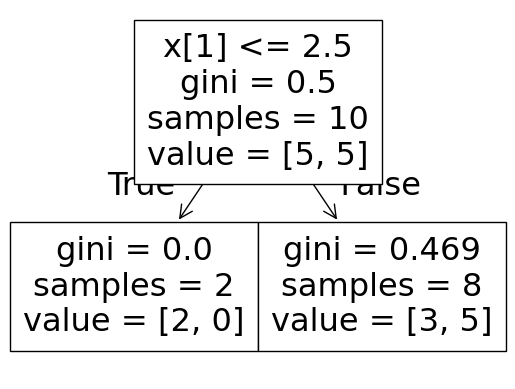

In [13]:
plot_tree(dt1)

/home/user550/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


<Axes: >

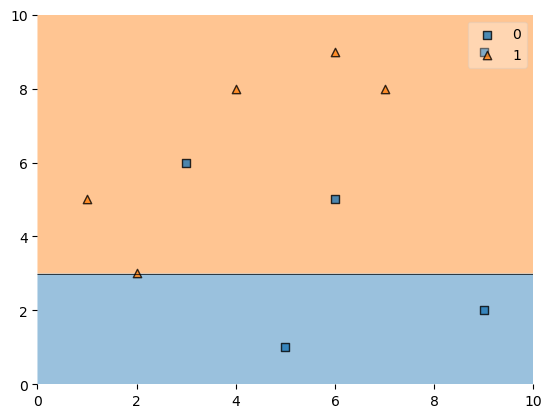

In [14]:
plot_decision_regions(x.values,y.values,clf=dt1)

### creating another column that contains the predicted values of the decision stump

In [15]:
df['y_pred'] = dt1.predict(x)

In [16]:
df

,X1,X2,label,weights,y_pred
0,1,5,1,0.1,1
1,2,3,1,0.1,1
2,3,6,0,0.1,1
3,4,8,1,0.1,1
4,5,1,0,0.1,0
5,6,9,1,0.1,1
6,6,5,0,0.1,1
7,7,8,1,0.1,1
8,9,9,0,0.1,1
9,9,2,0,0.1,0


### function for initializing the model weight and the added very small quantity to ensure that the denominator never becomes zero

In [17]:
def model_weight(df):
    error = 0
    for _,row in df.iterrows():
        if row['label']!=row['y_pred']:
            error+=row['weights']

    return 0.5*np.log((1-error)/(error+0.0000000001))

In [18]:
alpha1 = model_weight(df)

In [19]:
alpha1

np.float64(0.42364893002693504)

### function for updating the weights using the model weight

In [20]:
def update_weights(row,alpha = alpha1):
    if row['label']!=row['y_pred']:
        return row['weights']*np.exp(-alpha)
    else:
        return row['weights']*np.exp(alpha)
    

In [21]:
df['updated_weights'] = df.apply(update_weights,axis=1)

In [22]:
df

,X1,X2,label,weights,y_pred,updated_weights
0,1,5,1,0.1,1,0.152753
1,2,3,1,0.1,1,0.152753
2,3,6,0,0.1,1,0.065465
3,4,8,1,0.1,1,0.152753
4,5,1,0,0.1,0,0.152753
5,6,9,1,0.1,1,0.152753
6,6,5,0,0.1,1,0.065465
7,7,8,1,0.1,1,0.152753
8,9,9,0,0.1,1,0.065465
9,9,2,0,0.1,0,0.152753


#### as the updated weights dont add up to 1, we need to normalise them

In [23]:
df['normalised_weights'] = df['updated_weights']/df['updated_weights'].sum()

In [24]:
df

,X1,X2,label,weights,y_pred,updated_weights,normalised_weights
0,1,5,1,0.1,1,0.152753,0.120690
1,2,3,1,0.1,1,0.152753,0.120690
2,3,6,0,0.1,1,0.065465,0.051724
3,4,8,1,0.1,1,0.152753,0.120690
4,5,1,0,0.1,0,0.152753,0.120690
5,6,9,1,0.1,1,0.152753,0.120690
6,6,5,0,0.1,1,0.065465,0.051724
7,7,8,1,0.1,1,0.152753,0.120690
8,9,9,0,0.1,1,0.065465,0.051724
9,9,2,0,0.1,0,0.152753,0.120690


In [25]:
df['normalised_weights'].sum()

np.float64(1.0)

### creating a range for the normalised weights

In [26]:
df['cumsum_upper'] = np.cumsum(df['normalised_weights'])
df['cumsum_lower'] = df['cumsum_upper'] - df['normalised_weights']
df[['X1','X2','label','weights','y_pred','updated_weights','cumsum_lower','cumsum_upper']]

,X1,X2,label,weights,y_pred,updated_weights,cumsum_lower,cumsum_upper
0,1,5,1,0.1,1,0.152753,0.000000,0.120690
1,2,3,1,0.1,1,0.152753,0.120690,0.241379
2,3,6,0,0.1,1,0.065465,0.241379,0.293103
3,4,8,1,0.1,1,0.152753,0.293103,0.413793
4,5,1,0,0.1,0,0.152753,0.413793,0.534483
5,6,9,1,0.1,1,0.152753,0.534483,0.655172
6,6,5,0,0.1,1,0.065465,0.655172,0.706897
7,7,8,1,0.1,1,0.152753,0.706897,0.827586
8,9,9,0,0.1,1,0.065465,0.827586,0.879310
9,9,2,0,0.1,0,0.152753,0.879310,1.000000


### getting randomly selected rows using the range we created above

In [27]:
def create_new_dataset(df):

  indices = []

  for i in range(df.shape[0]):
    a = np.random.random()
    for index,row in df.iterrows():
      if row['cumsum_upper'] > a and a > row['cumsum_lower']:
        indices.append(index)
  return indices

In [28]:
index_values = create_new_dataset(df)

In [29]:
index_values

[4, 4, 0, 1, 7, 0, 3, 4, 7, 1]

### creating a second dataframe with the rows selected randomly from the previous dataframe and the weights are equally distributed here (the next process in adaboost)

In [30]:
second_df = df.iloc[index_values,[0,1,2,3]]


# Doing all the same thing to the second_df as we did in the previous df

In [31]:
second_df

,X1,X2,label,weights
4,5,1,0,0.1
4,5,1,0,0.1
0,1,5,1,0.1
1,2,3,1,0.1
7,7,8,1,0.1
0,1,5,1,0.1
3,4,8,1,0.1
4,5,1,0,0.1
7,7,8,1,0.1
1,2,3,1,0.1


In [32]:
dt2 = DecisionTreeClassifier(max_depth=1)

In [33]:
x = second_df.iloc[:,0:2]
y = second_df.iloc[:,2]

In [34]:
dt2.fit(x,y)

DecisionTreeClassifier(max_depth=1)

In [35]:
second_df['y_pred'] = dt2.predict(x)

In [36]:
second_df

,X1,X2,label,weights,y_pred
4,5,1,0,0.1,0
4,5,1,0,0.1,0
0,1,5,1,0.1,1
1,2,3,1,0.1,1
7,7,8,1,0.1,1
0,1,5,1,0.1,1
3,4,8,1,0.1,1
4,5,1,0,0.1,0
7,7,8,1,0.1,1
1,2,3,1,0.1,1


In [37]:
alpha2 = model_weight(second_df)

In [38]:
alpha2

np.float64(11.512925464970229)

In [39]:
second_df['updated_weights'] = second_df.apply(update_weights,axis=1)

In [40]:
second_df

,X1,X2,label,weights,y_pred,updated_weights
4,5,1,0,0.1,0,0.152753
4,5,1,0,0.1,0,0.152753
0,1,5,1,0.1,1,0.152753
1,2,3,1,0.1,1,0.152753
7,7,8,1,0.1,1,0.152753
0,1,5,1,0.1,1,0.152753
3,4,8,1,0.1,1,0.152753
4,5,1,0,0.1,0,0.152753
7,7,8,1,0.1,1,0.152753
1,2,3,1,0.1,1,0.152753


In [41]:
second_df['normalised_weights'] = second_df['updated_weights']/second_df['updated_weights'].sum()

In [42]:
second_df

,X1,X2,label,weights,y_pred,updated_weights,normalised_weights
4,5,1,0,0.1,0,0.152753,0.1
4,5,1,0,0.1,0,0.152753,0.1
0,1,5,1,0.1,1,0.152753,0.1
1,2,3,1,0.1,1,0.152753,0.1
7,7,8,1,0.1,1,0.152753,0.1
0,1,5,1,0.1,1,0.152753,0.1
3,4,8,1,0.1,1,0.152753,0.1
4,5,1,0,0.1,0,0.152753,0.1
7,7,8,1,0.1,1,0.152753,0.1
1,2,3,1,0.1,1,0.152753,0.1


In [43]:
second_df['cumsum_upper'] = np.cumsum(second_df['normalised_weights'])
second_df['cumsum_lower'] = second_df['cumsum_upper'] - second_df['normalised_weights']
second_df[['X1','X2','label','weights','y_pred','updated_weights','cumsum_lower','cumsum_upper']]

,X1,X2,label,weights,y_pred,updated_weights,cumsum_lower,cumsum_upper
4,5,1,0,0.1,0,0.152753,0.0,0.1
4,5,1,0,0.1,0,0.152753,0.1,0.2
0,1,5,1,0.1,1,0.152753,0.2,0.3
1,2,3,1,0.1,1,0.152753,0.3,0.4
7,7,8,1,0.1,1,0.152753,0.4,0.5
0,1,5,1,0.1,1,0.152753,0.5,0.6
3,4,8,1,0.1,1,0.152753,0.6,0.7
4,5,1,0,0.1,0,0.152753,0.7,0.8
7,7,8,1,0.1,1,0.152753,0.8,0.9
1,2,3,1,0.1,1,0.152753,0.9,1.0


In [44]:
index2 = create_new_dataset(second_df)

In [45]:
index2

[7, 4, 4, 1, 0, 7, 1, 4, 4, 4]

### creating a third dataframe

In [46]:
third_df = second_df.iloc[index_values,[0,1,2,3]]

# Doing everything same for the third dataframe too

In [47]:
third_df

,X1,X2,label,weights
7,7,8,1,0.1
7,7,8,1,0.1
4,5,1,0,0.1
4,5,1,0,0.1
4,5,1,0,0.1
4,5,1,0,0.1
1,2,3,1,0.1
7,7,8,1,0.1
4,5,1,0,0.1
4,5,1,0,0.1


In [48]:
dt3 = DecisionTreeClassifier(max_depth=1)

In [49]:
x = third_df.iloc[:,0:2]
y = third_df.iloc[:,2]

In [50]:
dt3.fit(x,y)

DecisionTreeClassifier(max_depth=1)

In [51]:
third_df['y_pred'] = dt3.predict(x)

In [52]:
third_df

,X1,X2,label,weights,y_pred
7,7,8,1,0.1,1
7,7,8,1,0.1,1
4,5,1,0,0.1,0
4,5,1,0,0.1,0
4,5,1,0,0.1,0
4,5,1,0,0.1,0
1,2,3,1,0.1,1
7,7,8,1,0.1,1
4,5,1,0,0.1,0
4,5,1,0,0.1,0


In [53]:
alpha3 = model_weight(third_df)

In [54]:
alpha3

np.float64(11.512925464970229)

### Prediction

In [55]:
query = np.array([1,5]).reshape(1,2)

In [56]:
dt1.predict(query)

/home/user550/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


array([1])

In [57]:
dt2.predict(query)

/home/user550/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


array([1])

In [58]:
dt3.predict(query)

/home/user550/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


array([1])

In [59]:
alpha1*1 + alpha2*(1) + alpha3*(1)

np.float64(23.449499859967393)

In [60]:
np.sign(alpha1*1 + alpha2*(1) + alpha3*(1))

np.float64(1.0)

In [61]:
query = np.array([9,9]).reshape(1,2)

In [62]:
dt1.predict(query)

/home/user550/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


array([1])

In [63]:
dt2.predict(query)

/home/user550/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


array([1])

In [64]:
dt3.predict(query)

/home/user550/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


array([1])

In [65]:
np.sign(alpha1*1 + alpha2*(0) + alpha3*(0))

np.float64(1.0)